# Flood Model Training Notebook

Train a Flood ConvLSTM Model using `usl_models` lib.

In [1]:
import tensorflow as tf
import keras_tuner
import time
import keras
import logging
from usl_models.flood_ml import constants
from usl_models.flood_ml.model import FloodModel
from usl_models.flood_ml.model_params import FloodModelParams
from usl_models.flood_ml.dataset import load_dataset_windowed, load_dataset
from usl_models.flood_ml import customloss, dataset

# Setup
logging.getLogger().setLevel(logging.WARNING)
keras.utils.set_random_seed(812)

for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

timestamp = time.strftime("%Y%m%d-%H%M%S")

# Cities and their config folders
city_config_mapping = {
    "Manhattan": "Manhattan_config",
    "Atlanta": "Atlanta_config",
    # "Phoenix_SM": "PHX_SM",
    # "Phoenix_PV": "PHX_PV",
}

# Rainfall files you want
rainfall_files = [5]  # Only 5 and 6

# Generate sim_names
sim_names = []
for city, config in city_config_mapping.items():
    for rain_id in rainfall_files:
        sim_name = f"{city}-{config}/Rainfall_Data_{rain_id}.txt"
        sim_names.append(sim_name)

print(f"Training on {len(sim_names)} simulations.")
for s in sim_names:
    print(s)

# Now load dataset
ds_config = dataset.Config(
    input_height=3, input_width=3,
    output_height=3, output_width=3
)

train_dataset = load_dataset_windowed(
    sim_names=sim_names, batch_size=4, dataset_split="train", ds_config=ds_config
).cache()

validation_dataset = load_dataset_windowed(
    sim_names=sim_names, batch_size=4, dataset_split="val", ds_config=ds_config
).cache()

2025-06-23 22:58:01.272342: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-23 22:58:01.322727: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-23 22:58:01.322753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-23 22:58:01.324036: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-23 22:58:01.331882: I tensorflow/core/platform/cpu_feature_guar

Training on 2 simulations.
Manhattan-Manhattan_config/Rainfall_Data_5.txt
Atlanta-Atlanta_config/Rainfall_Data_5.txt


2025-06-23 22:58:06.533657: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38364 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


In [2]:
log_dir = f"logs/htune_project_{timestamp}"
print(log_dir)
tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

tuner = keras_tuner.BayesianOptimization(
    FloodModel.get_hypermodel(
        lstm_units=[32, 64, 128],
        lstm_kernel_size=[3, 5],
        lstm_dropout=[0.2, 0.3],
        lstm_recurrent_dropout=[0.2, 0.3],
        n_flood_maps=[5],
        m_rainfall=[6],
        loss_scale=[50.0, 100.0, 200.0],
    ),
    objective="val_loss",
    max_trials=1,
    project_name=log_dir,
)

tuner.search(
    train_dataset,
    epochs=2,
    validation_data=validation_dataset,
    callbacks=[tb_callback],
)

best_model, best_hp = tuner.get_best_models()[0], tuner.get_best_hyperparameters()[0]
best_hp.values

Trial 1 Complete [00h 01m 16s]
val_loss: 0.0054555246606469154

Best val_loss So Far: 0.0054555246606469154
Total elapsed time: 00h 01m 16s


{'lstm_units': 64,
 'lstm_kernel_size': 3,
 'lstm_dropout': 0.3,
 'lstm_recurrent_dropout': 0.3,
 'n_flood_maps': 5,
 'm_rainfall': 6,
 'loss_scale': 200.0}

In [ ]:
tuner = keras_tuner.BayesianOptimization(
    FloodModel.get_hypermodel(
        lstm_units=[32, 64, 128],
        lstm_kernel_size=[3, 5],
        lstm_dropout=[0.2, 0.3],
        lstm_recurrent_dropout=[0.2, 0.3],
        n_flood_maps=[5],
        m_rainfall=[6],
        loss_scale=[50.0, 100.0, 200.0],
    ),
    objective="val_loss",
    max_trials=10,
    project_name=f"logs/htune_project_{timestamp}",
)

tuner.search_space_summary()

In [ ]:
log_dir = f"logs/htune_project_{timestamp}"
print(log_dir)
tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
tuner.search(
    train_dataset,
    epochs=2,
    validation_data=validation_dataset,
    callbacks=[tb_callback],
)
best_model, best_hp = tuner.get_best_models()[0], tuner.get_best_hyperparameters()[0]
best_hp.values

In [3]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define final parameters and model
final_params_dict = best_hp.values.copy()
loss_scale = final_params_dict.pop("loss_scale", 100.0)
final_params = FloodModel.Params(**final_params_dict)
model = FloodModel(params=final_params, loss_scale=loss_scale)
# Define callbacks
callbacks = [
    keras.callbacks.TensorBoard(log_dir=log_dir),
    ModelCheckpoint(
        filepath=log_dir + "/checkpoint",
        save_best_only=True,
        monitor="val_loss",
        mode="min",
        save_format="tf",
    ),
    EarlyStopping(  # <--- ADD THIS
        monitor="val_loss",  # What to monitor
        patience=100,  # Number of epochs with no improvement to wait
        restore_best_weights=True,  # Restore model weights from best epoch
        mode="min",  # "min" because lower val_loss is better
    ),
]

# Train
model.fit(train_dataset, validation_dataset, epochs=4, callbacks=callbacks)

model.save_model(log_dir + "/model")

Epoch 1/4


2025-06-23 22:59:30.191283: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inflood_conv_lstm_1/conv_lstm/conv_lstm2d_1/while/body/_1/flood_conv_lstm_1/conv_lstm/conv_lstm2d_1/while/dropout_7/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


     89/Unknown - 8s 25ms/step - loss: 0.0050 - mean_absolute_error: 0.0285 - root_mean_squared_error: 0.1020

2025-06-23 22:59:34.452158: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8789292211820607917
2025-06-23 22:59:34.452205: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9747076174380895616
2025-06-23 22:59:34.452213: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 755160174649028238
2025-06-23 22:59:35.200692: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10218923822016254689


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac88101210>, 140378061020656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac88101210>, 140378061020656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac503b1850>, 140378061025920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac503b1850>, 140378061025920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac503bc890>, 140378059991488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac503bc890>, 140378059991488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac50208950>, 140378059991824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac50208950>, 140378059991824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac88101210>, 140378061020656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac88101210>, 140378061020656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac503b1850>, 140378061025920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac503b1850>, 140378061025920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac503bc890>, 140378059991488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac503bc890>, 140378059991488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac50208950>, 140378059991824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac50208950>, 140378059991824), {}).


INFO:tensorflow:Assets written to: logs/htune_project_20250623-225804/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250623-225804/checkpoint/assets


91/91 [==============================] - 13s 84ms/step - loss: 0.0049 - mean_absolute_error: 0.0279 - root_mean_squared_error: 0.1009 - val_loss: 0.0055 - val_mean_absolute_error: 0.0228 - val_root_mean_squared_error: 0.1161
Epoch 2/4
91/91 [==============================] - 3s 28ms/step - loss: 0.0049 - mean_absolute_error: 0.0279 - root_mean_squared_error: 0.1009 - val_loss: 0.0055 - val_mean_absolute_error: 0.0228 - val_root_mean_squared_error: 0.1161
Epoch 3/4
91/91 [==============================] - 2s 27ms/step - loss: 0.0049 - mean_absolute_error: 0.0279 - root_mean_squared_error: 0.1009 - val_loss: 0.0055 - val_mean_absolute_error: 0.0228 - val_root_mean_squared_error: 0.1161
Epoch 4/4
91/91 [==============================] - 3s 27ms/step - loss: 0.0049 - mean_absolute_error: 0.0279 - root_mean_squared_error: 0.1009 - val_loss: 0.0055 - val_mean_absolute_error: 0.0228 - val_root_mean_squared_error: 0.1161
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(sha

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac88101210>, 140378061020656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac503b1850>, 140378061025920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac503b1850>, 140378061025920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac503bc890>, 140378059991488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac503bc890>, 140378059991488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac50208950>, 140378059991824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac50208950>, 140378059991824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac88101210>, 140378061020656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac88101210>, 140378061020656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac503b1850>, 140378061025920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac503b1850>, 140378061025920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac503bc890>, 140378059991488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac503bc890>, 140378059991488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac50208950>, 140378059991824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fac50208950>, 140378059991824), {}).


INFO:tensorflow:Assets written to: logs/htune_project_20250623-225804/model/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250623-225804/model/assets


In [ ]:
# # Test calling the model on some data.
inputs, labels_ = next(iter(train_dataset))
prediction = model.call(inputs)
prediction.shape

In [ ]:
# # Test calling the model for n predictions
# full_dataset = load_dataset(sim_names=sim_names, batch_size=1)
# inputs, labels = next(iter(full_dataset))
# predictions = model.call_n(inputs, n=4)
# predictions.shape

In [7]:
model = FloodModel.from_checkpoint("/home/elhajjas/climateiq-cnn-11/logs/htune_project_20250623-225804/model")

In [9]:
# model_path = "/home/elhajjas/climateiq-cnn-11/logs/htune_project_20250623-223109/model"

# # Create the loss function with the correct scale
# loss_fn = customloss.make_hybrid_loss(scale=loss_scale)

# # Load model with custom loss function
# model = tf.keras.models.load_model(model_path, custom_objects={"loss_fn": loss_fn})

# model = AtmoModel.from_checkpoint("logs/main_20250319-204950/model")


# After refactor you already have this
model = FloodModel.from_checkpoint("/home/elhajjas/climateiq-cnn-11/logs/htune_project_20250623-225804/model")


ds_config = dataset.Config(
    input_width=3, input_height=3, output_width=3, output_height=3
)
val_ds = load_dataset_windowed(
    sim_names=sim_names, batch_size=4, dataset_split="val", ds_config=ds_config
).cache()

input_batch, label_batch = next(iter(val_ds))
pred_batch = model.call(input_batch)

2025-06-23 23:01:30.853027: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Sample 1 Prediction Stats:
  Min: 0.0
  Max: 0.0
  Mean: 0.0


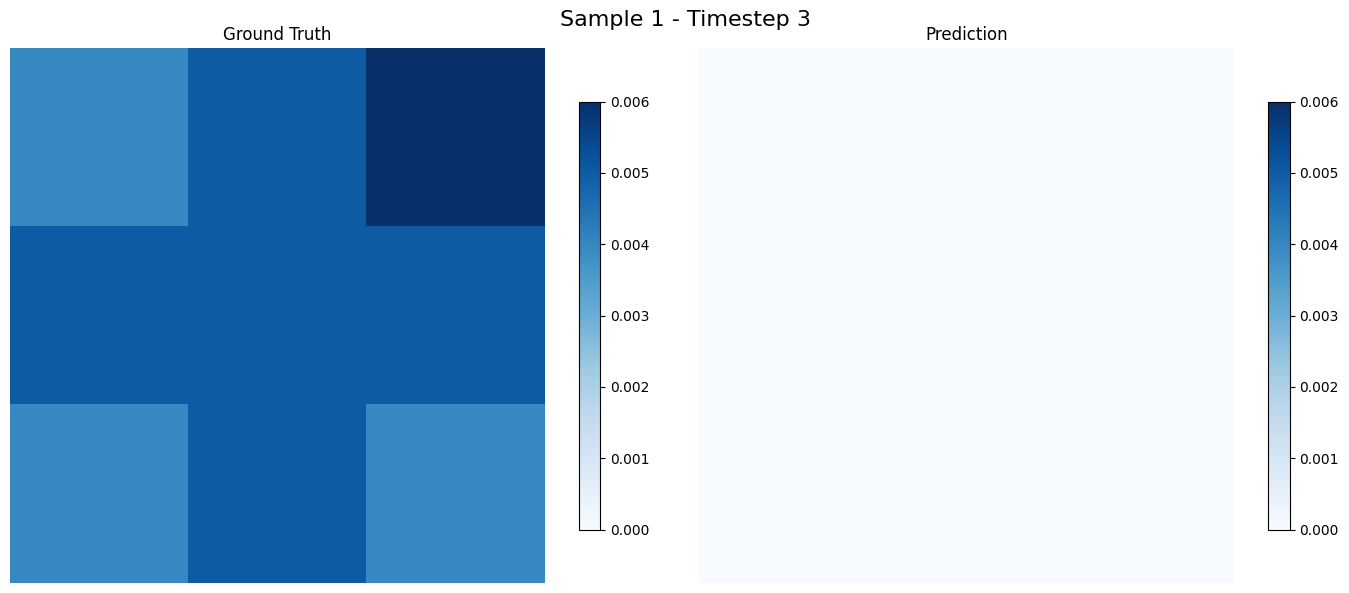


Sample 2 Prediction Stats:
  Min: 0.0
  Max: 0.0
  Mean: 0.0


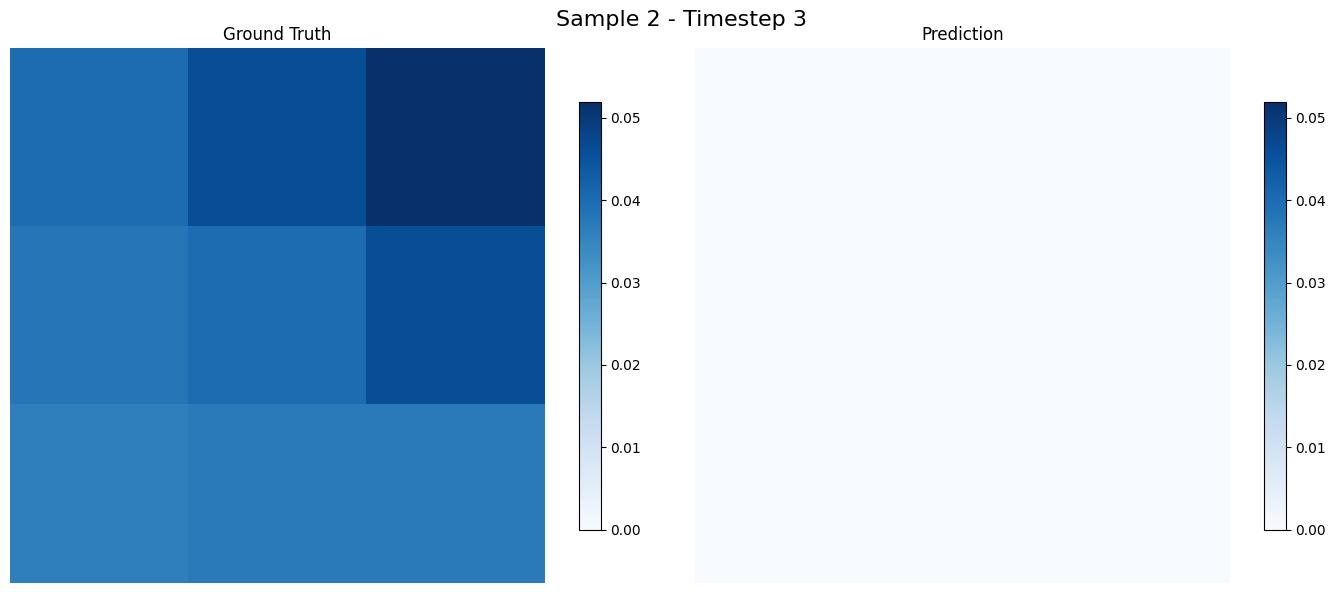


Sample 3 Prediction Stats:
  Min: 0.0
  Max: 0.0
  Mean: 0.0


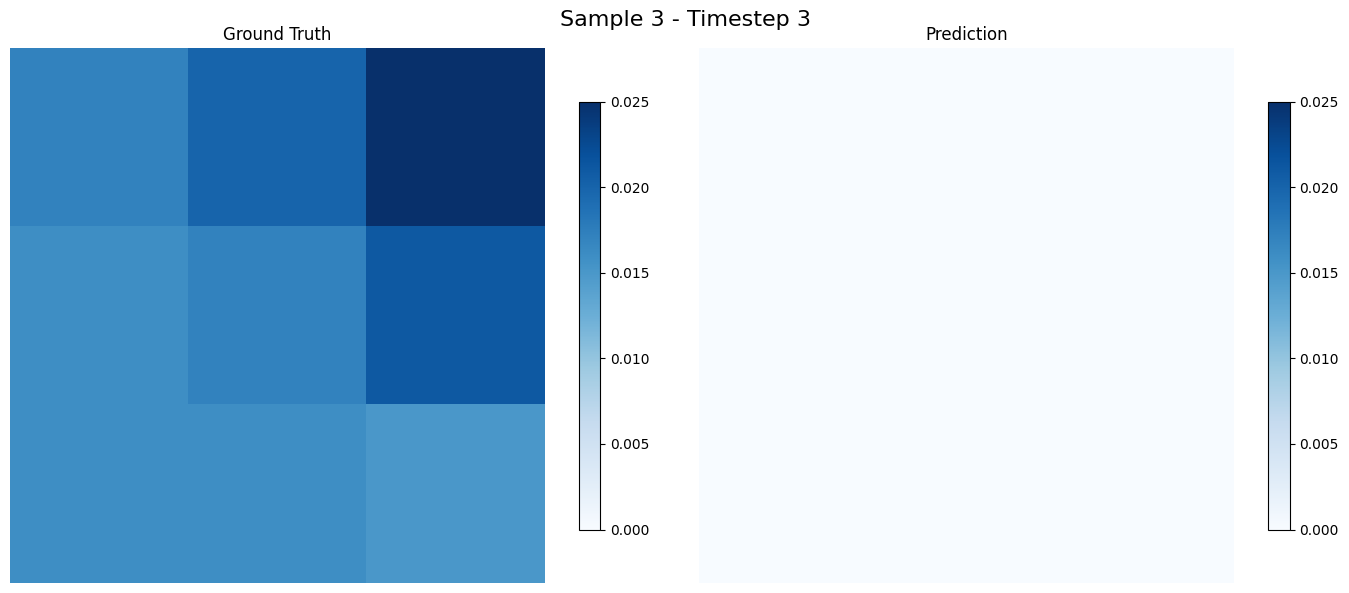


Sample 4 Prediction Stats:
  Min: 0.0
  Max: 0.0
  Mean: 0.0


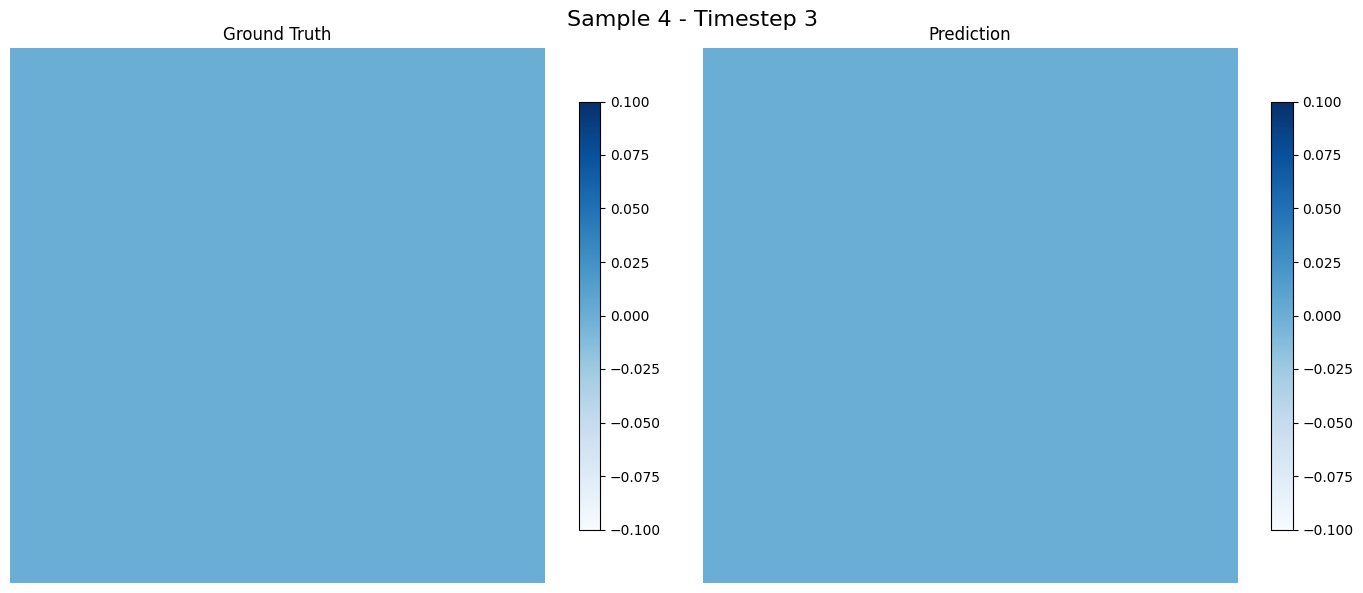


Sample 5 Prediction Stats:
  Min: 0.0
  Max: 0.0
  Mean: 0.0


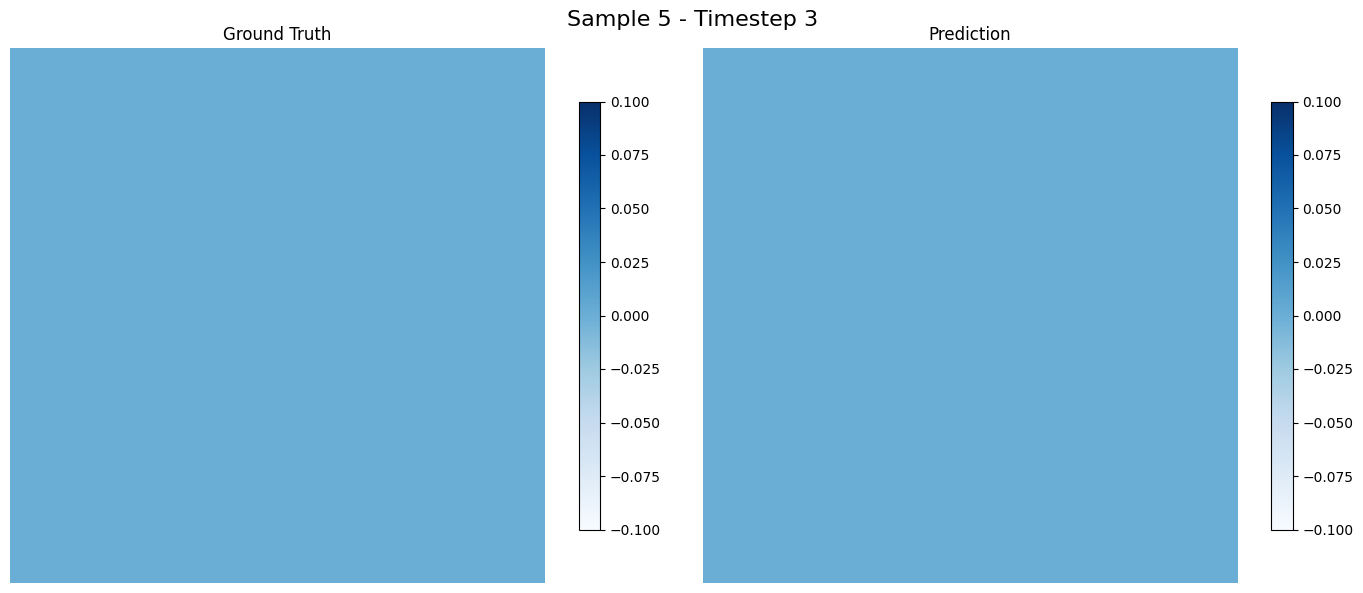


Sample 6 Prediction Stats:
  Min: 0.0
  Max: 0.0
  Mean: 0.0


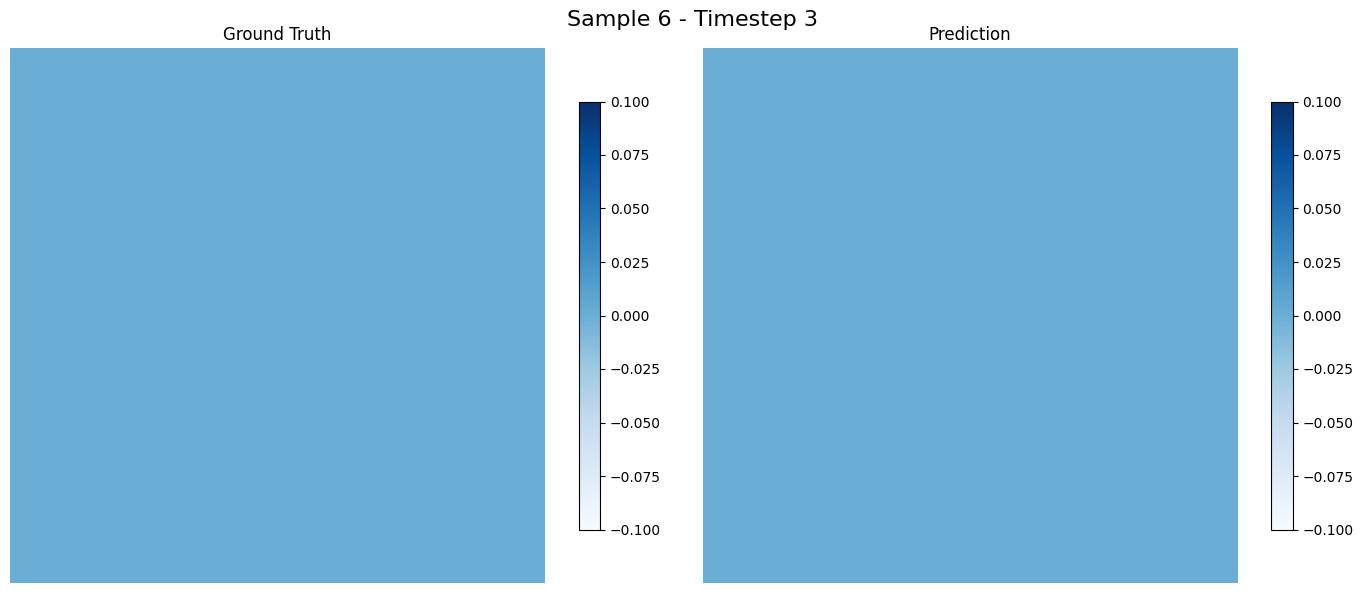


Sample 7 Prediction Stats:
  Min: 0.0
  Max: 0.0
  Mean: 0.0


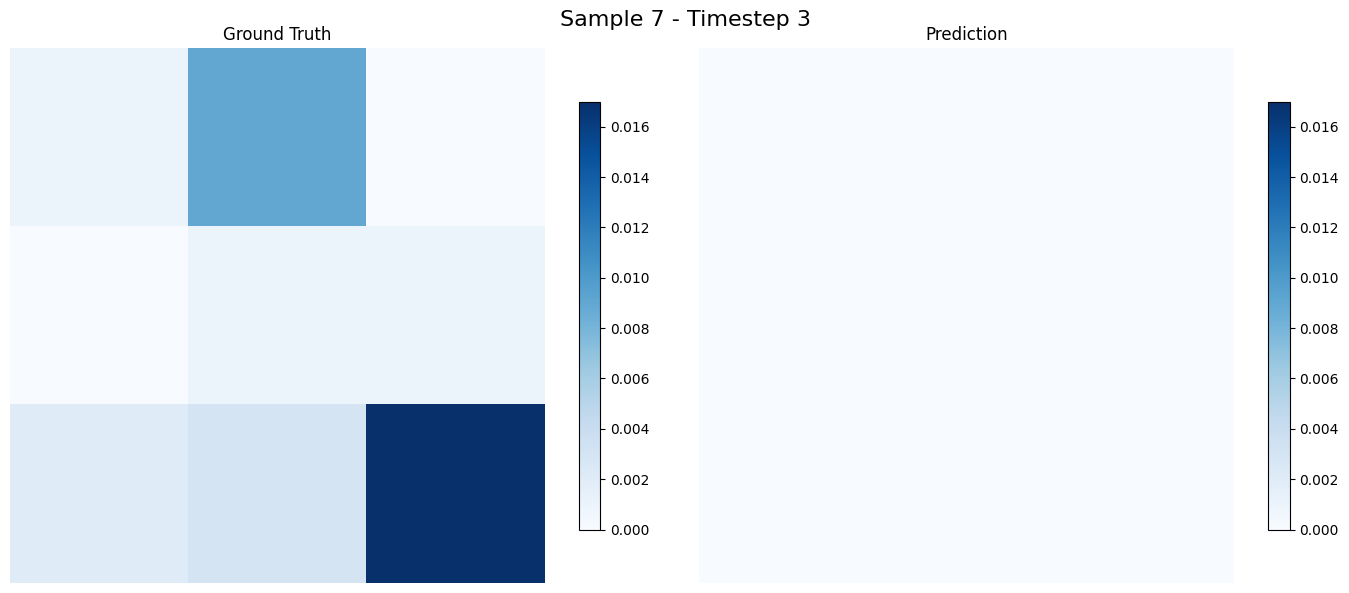


Sample 8 Prediction Stats:
  Min: 0.0
  Max: 0.0
  Mean: 0.0


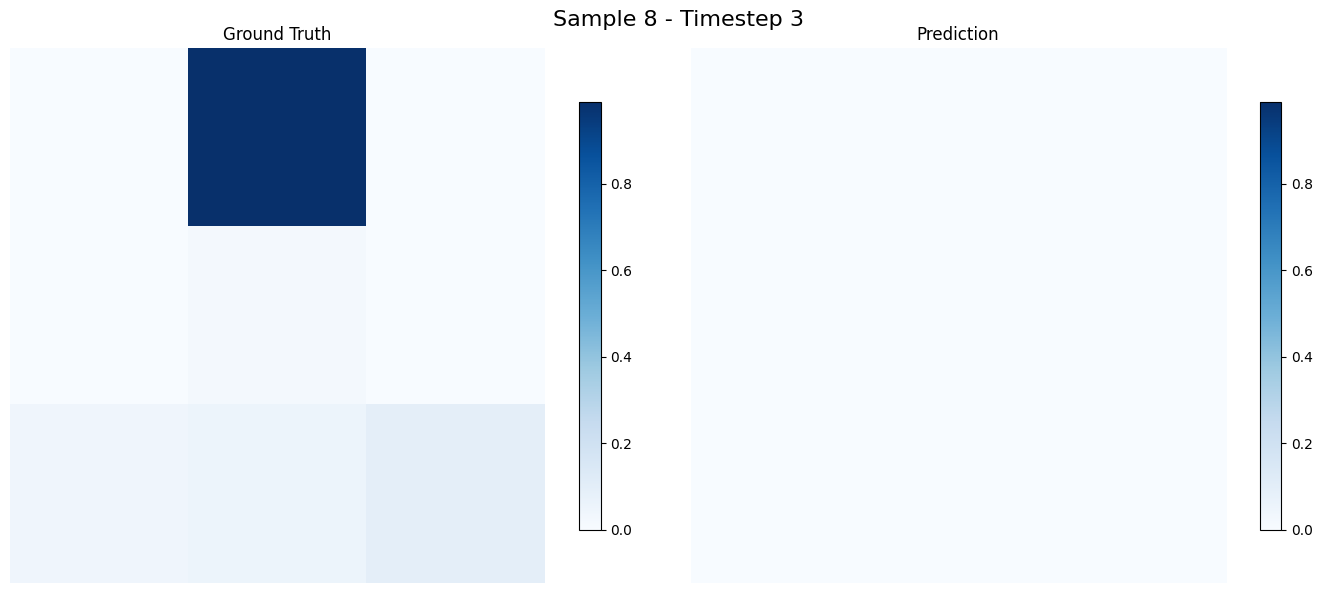


Sample 9 Prediction Stats:
  Min: 0.0
  Max: 0.0
  Mean: 0.0


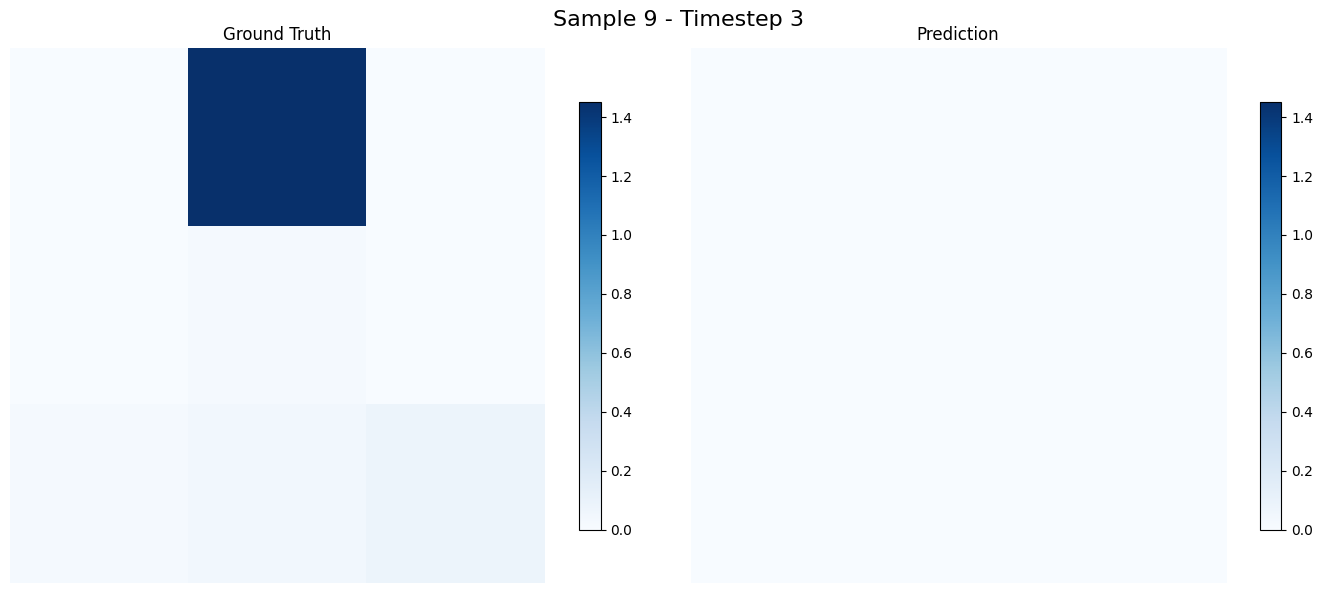


Sample 10 Prediction Stats:
  Min: 0.0
  Max: 0.0
  Mean: 0.0


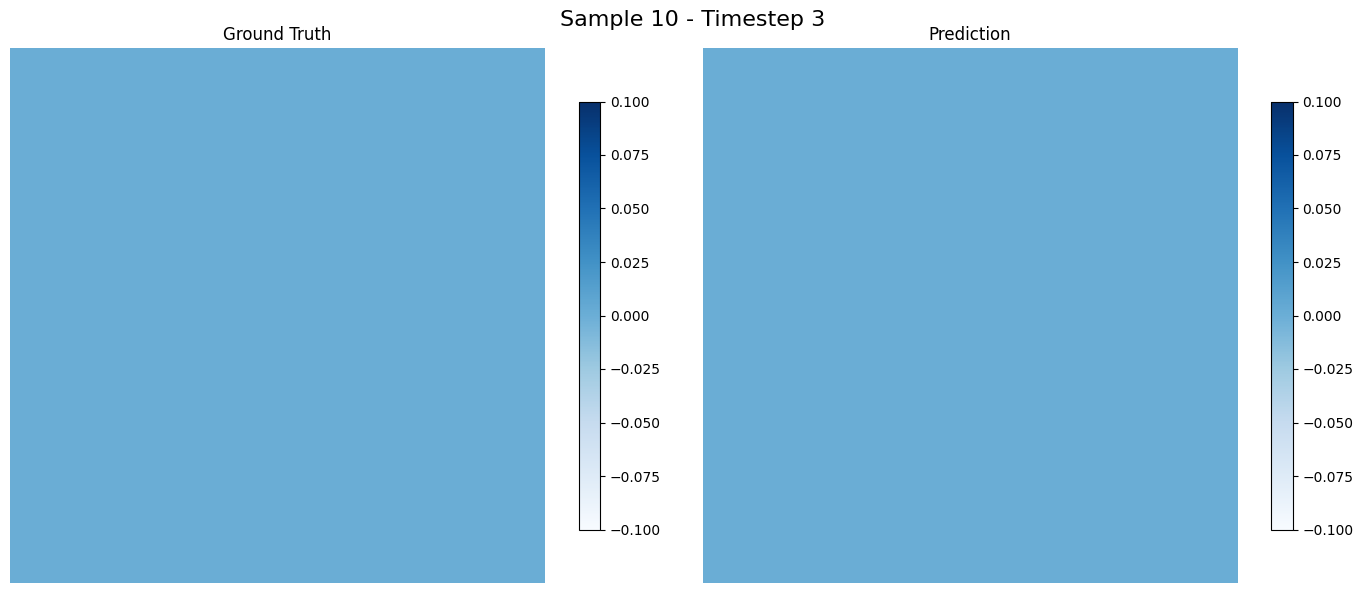


Sample 11 Prediction Stats:
  Min: 0.0
  Max: 0.0
  Mean: 0.0


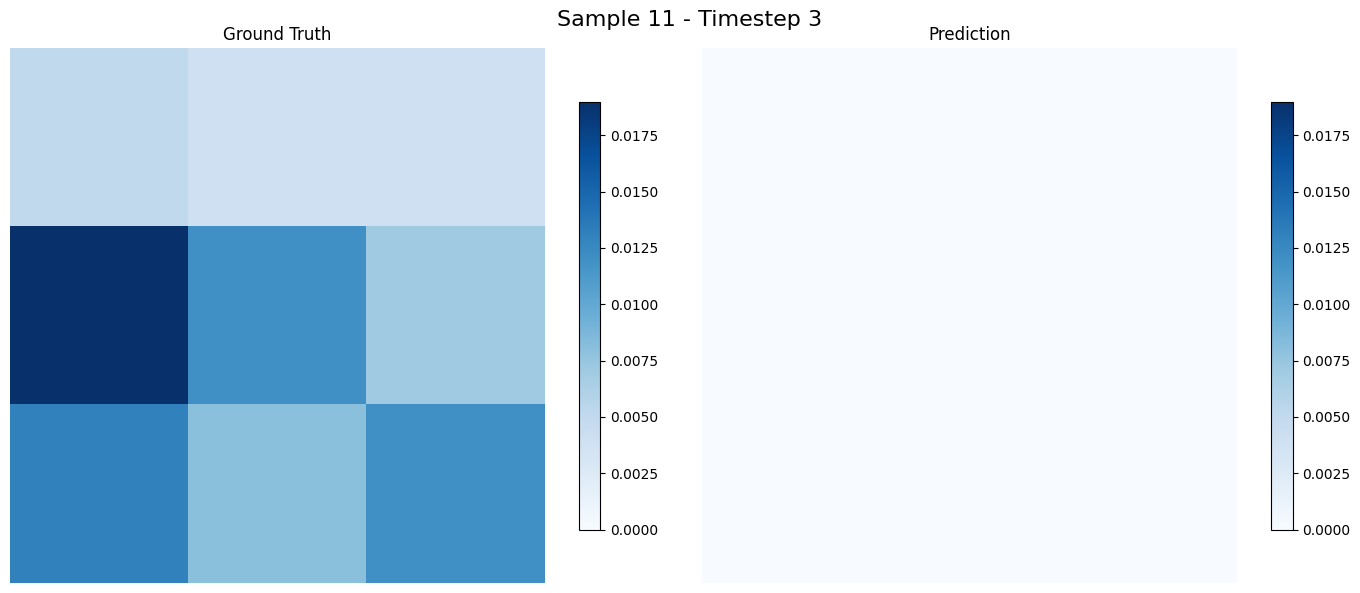


Sample 12 Prediction Stats:
  Min: 0.0
  Max: 0.0
  Mean: 0.0


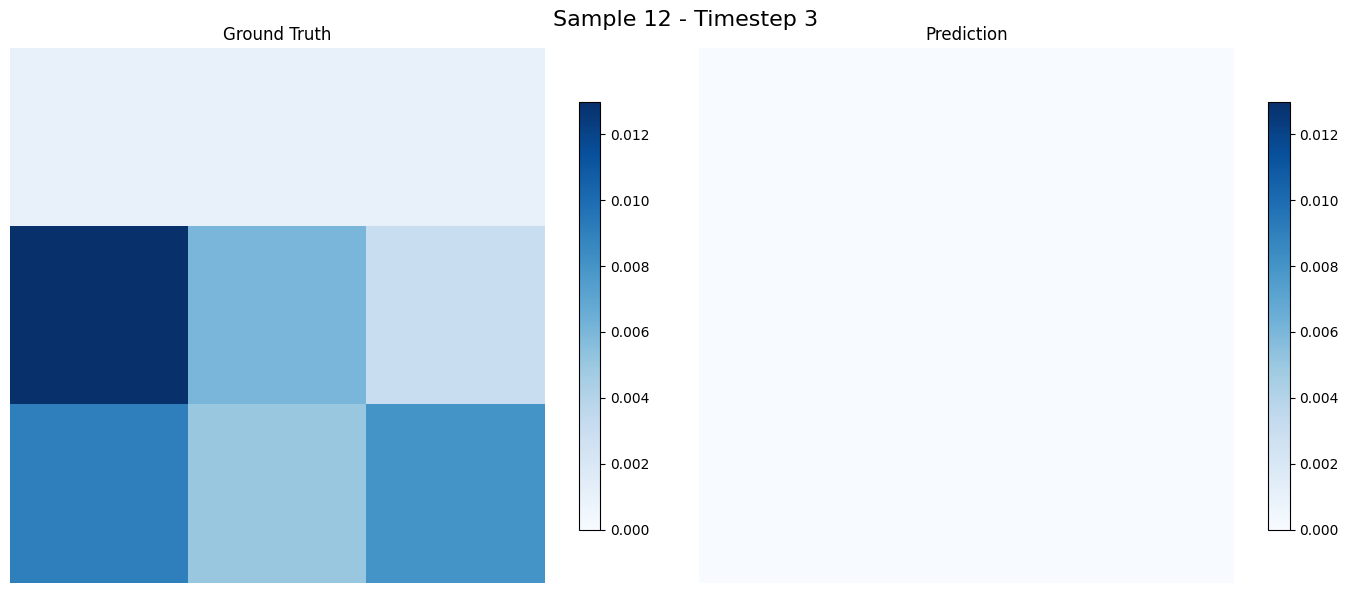


Sample 13 Prediction Stats:
  Min: 0.0
  Max: 0.0
  Mean: 0.0


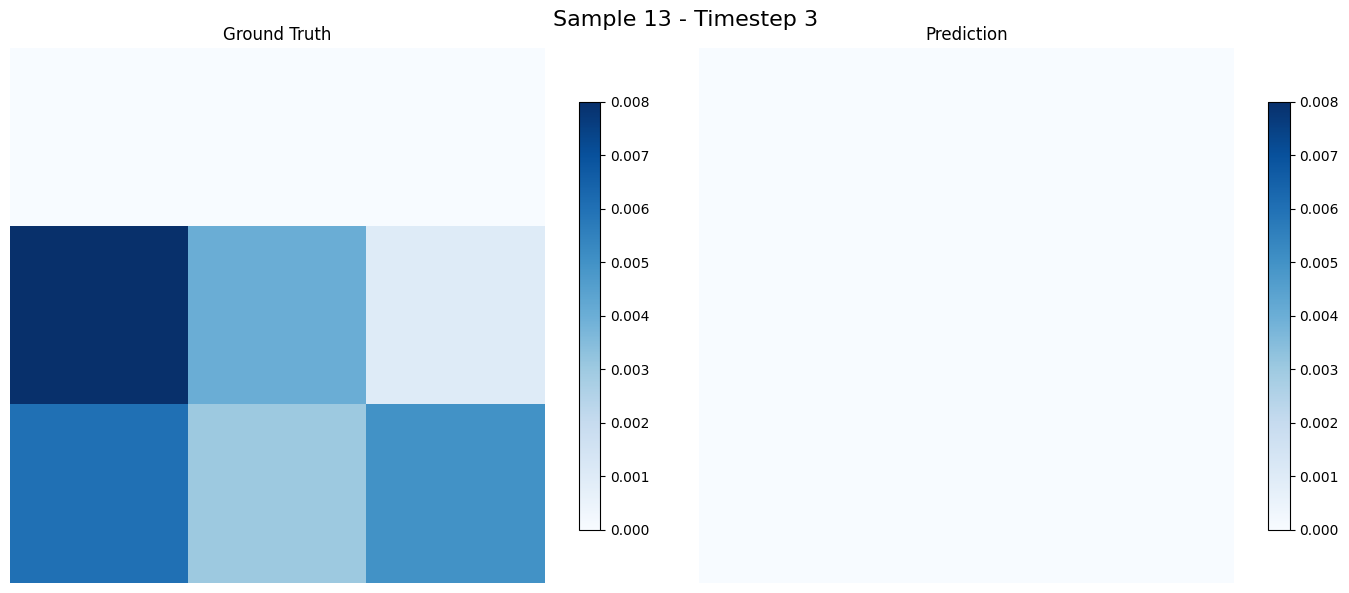


Sample 14 Prediction Stats:
  Min: 0.0
  Max: 0.0
  Mean: 0.0


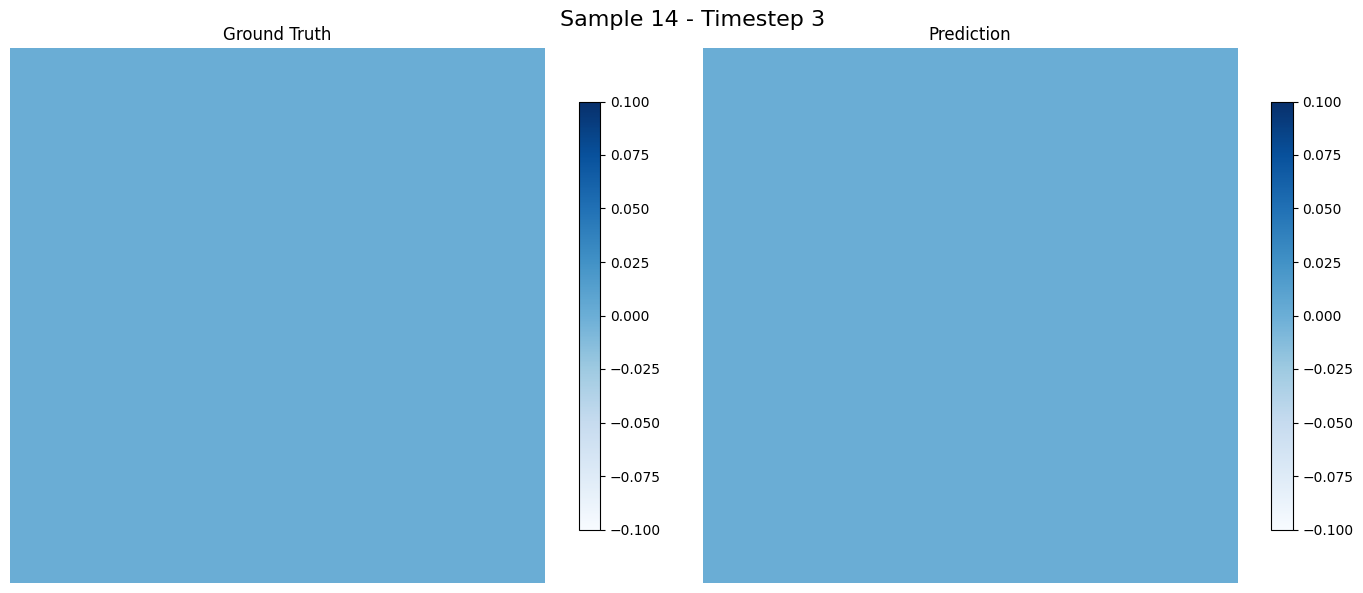


Sample 15 Prediction Stats:
  Min: 0.0
  Max: 0.0
  Mean: 0.0


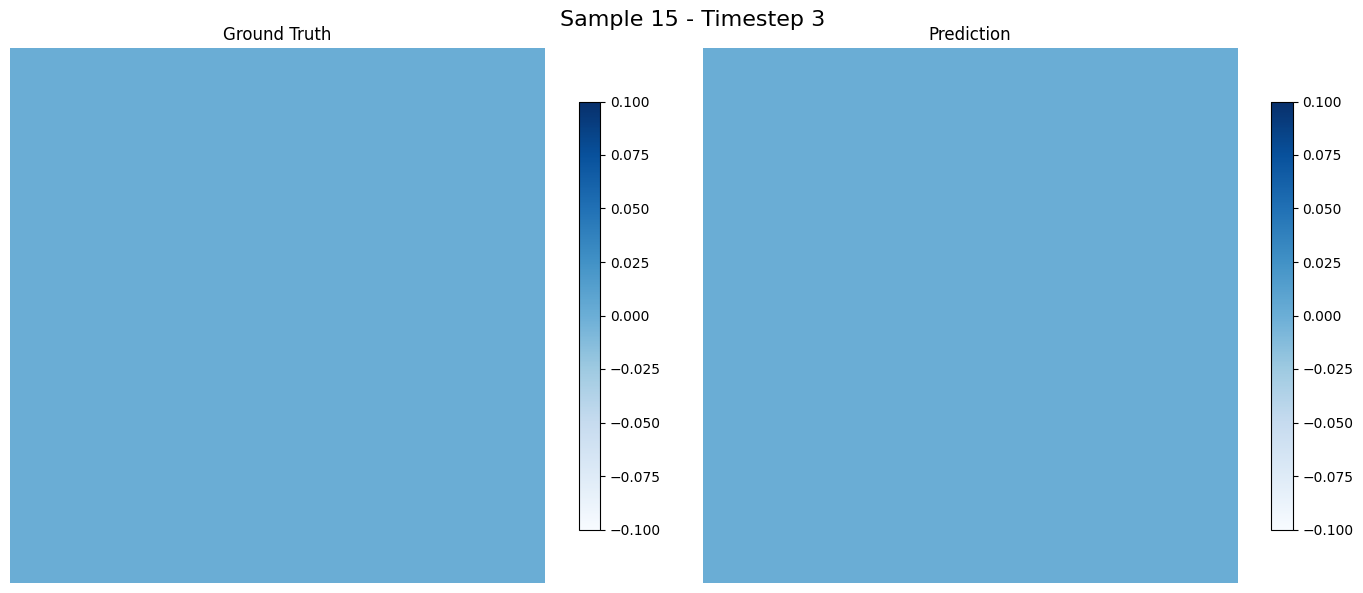


Sample 16 Prediction Stats:
  Min: 0.0
  Max: 0.0
  Mean: 0.0


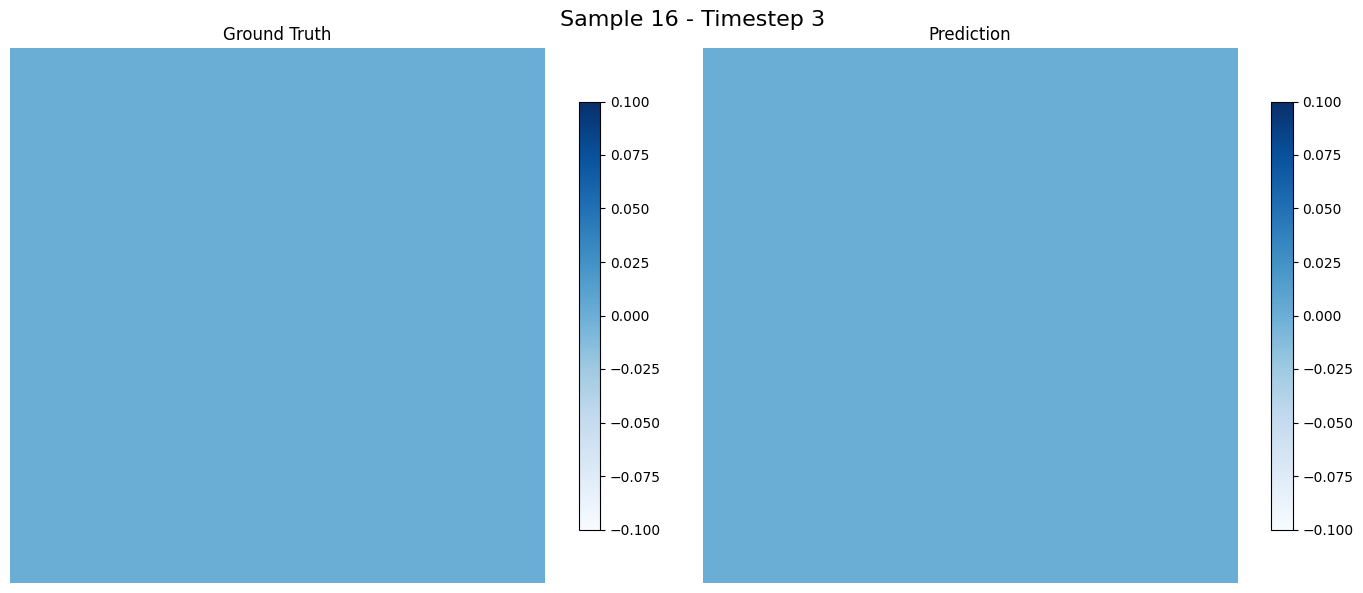


Sample 17 Prediction Stats:
  Min: 0.0
  Max: 0.0
  Mean: 0.0


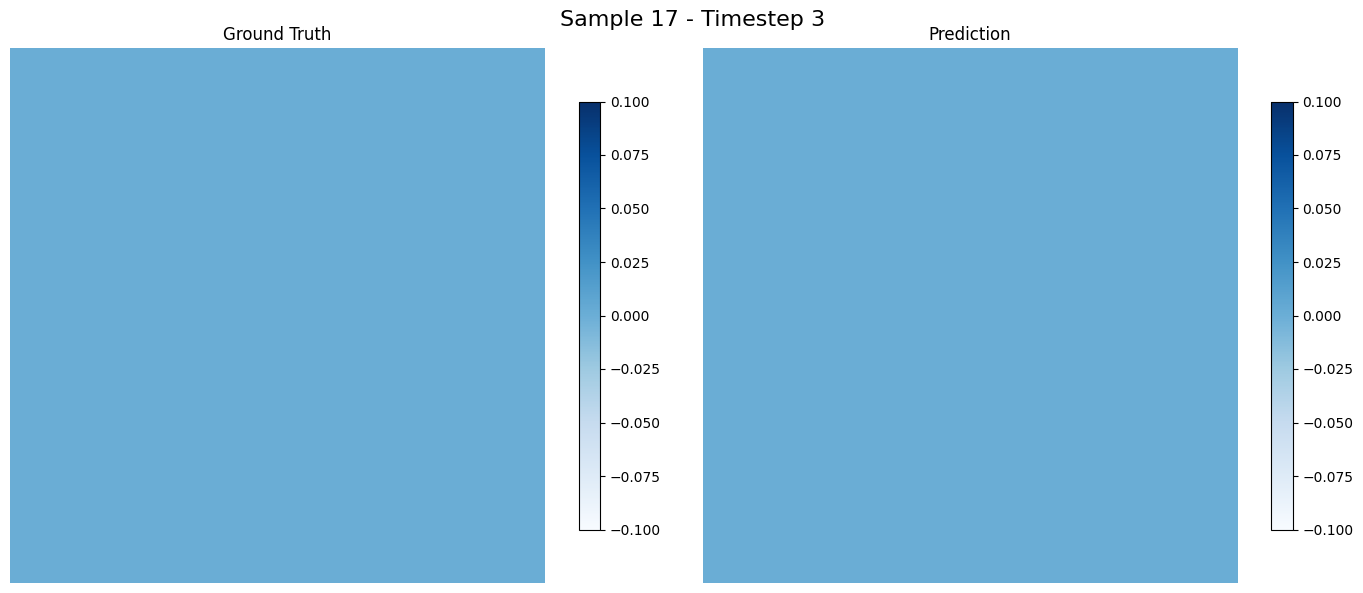


Sample 18 Prediction Stats:
  Min: 0.0
  Max: 0.0
  Mean: 0.0


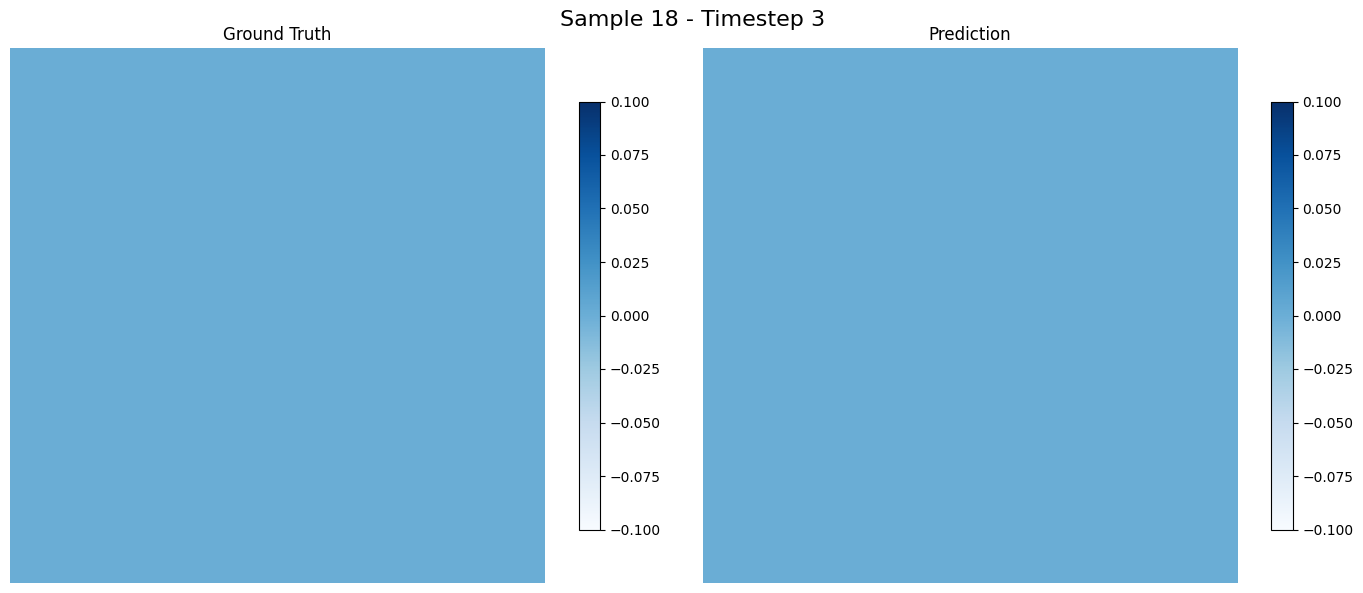


Sample 19 Prediction Stats:
  Min: 0.0
  Max: 0.0
  Mean: 0.0


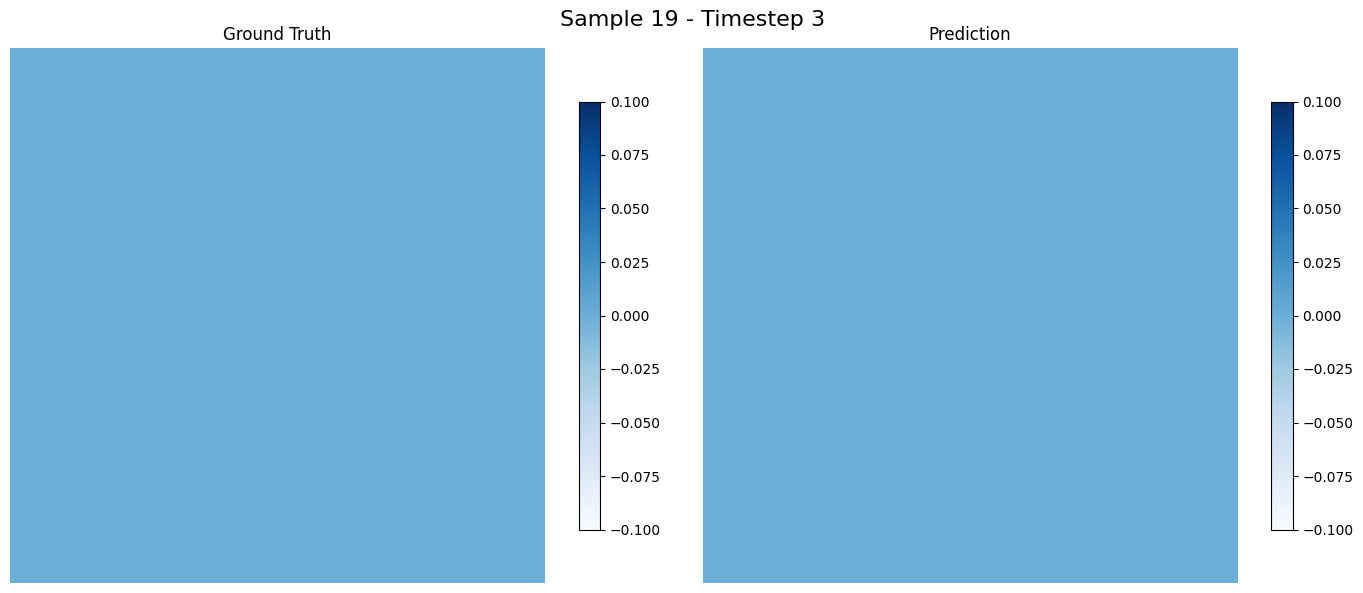

2025-06-23 23:02:31.957575: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Sample 20 Prediction Stats:
  Min: 0.0
  Max: 0.0
  Mean: 0.0


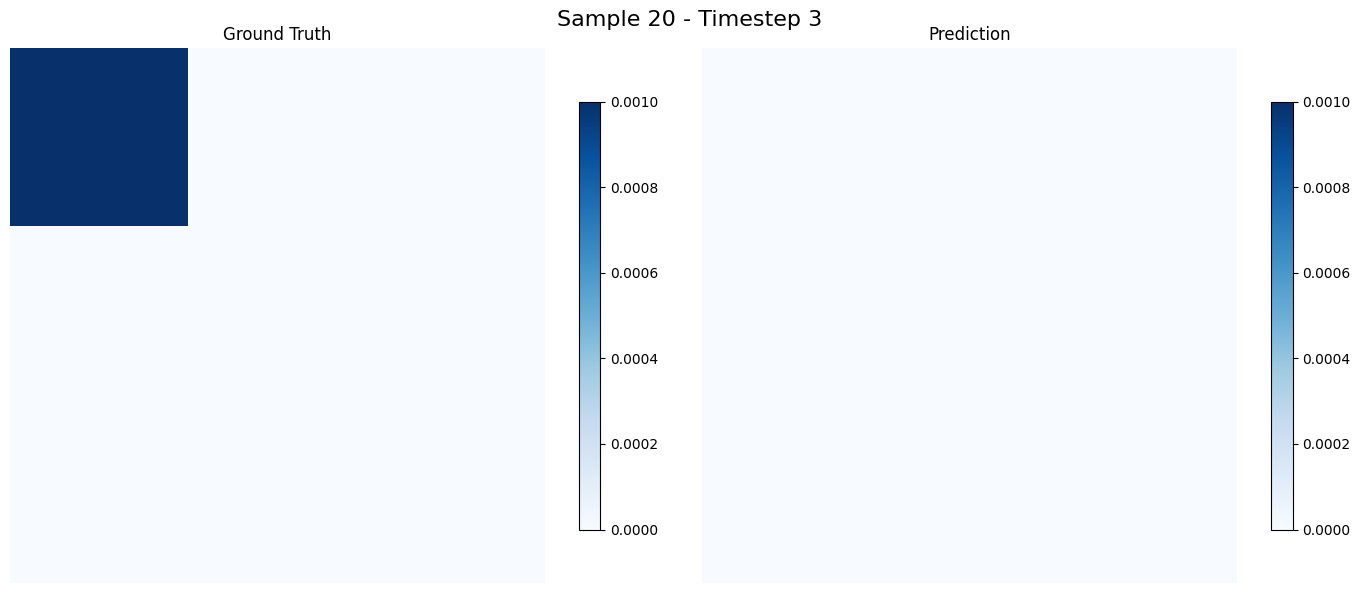

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from usl_models.flood_ml.dataset import load_dataset_windowed
from usl_models.flood_ml import constants

# Path to trained model
# Known value used during training
loss_scale = 200.0

# Path to trained model
model_path = "/home/elhajjas/climateiq-cnn-11/logs/htune_project_20250623-225804/model"

# Create the loss function with the correct scale
loss_fn = customloss.make_hybrid_loss(scale=loss_scale)

# Load model with custom loss function
model = tf.keras.models.load_model(model_path, custom_objects={"loss_fn": loss_fn})



# Number of samples to visualize
n_samples = 20

# Loop through the dataset and predict
for i, (input_data, ground_truth) in enumerate(val_ds.take(n_samples)):
    ground_truth = ground_truth.numpy().squeeze()
    prediction = model(input_data).numpy().squeeze()

    print(f"\nSample {i+1} Prediction Stats:")
    print("  Min:", prediction.min())
    print("  Max:", prediction.max())
    print("  Mean:", prediction.mean())

    # Choose timestep to plot
    timestep = 3
    gt_t = ground_truth[timestep]
    pred_t = prediction[timestep]
    vmax_val = max(gt_t.max(), pred_t.max())

    # Plot Ground Truth and Prediction
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Sample {i+1} - Timestep {timestep}", fontsize=16)

    im1 = axes[0].imshow(gt_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[0].set_title("Ground Truth")
    axes[0].axis("off")
    plt.colorbar(im1, ax=axes[0], shrink=0.8)

    im2 = axes[1].imshow(pred_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[1].set_title("Prediction")
    axes[1].axis("off")
    plt.colorbar(im2, ax=axes[1], shrink=0.8)

    plt.tight_layout()
    plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from usl_models.flood_ml.dataset import load_dataset_windowed
from usl_models.flood_ml import constants
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skimage.metrics import structural_similarity as ssim
import pandas as pd

# Path to trained model
# Known value used during training
loss_scale = 150.0

# Path to trained model
model_path = "/home/elhajjas/climateiq-cnn-11/usl_models/notebooks/logs/htune_project_20250611-205219/model"

# Create the loss function with the correct scale
loss_fn = customloss.make_hybrid_loss(scale=loss_scale)

# Load model with custom loss function
model = tf.keras.models.load_model(model_path, custom_objects={"loss_fn": loss_fn})


# Assuming validation_dataset is already defined
# Example:
# from usl_models.flood_ml.dataset import load_dataset_windowed
# validation_dataset = load_dataset_windowed(...)

n_samples = 20
timestep = 2
metrics_list = []

for i, (input_data, ground_truth) in enumerate(validation_dataset.take(n_samples)):
    ground_truth = ground_truth.numpy().squeeze()
    prediction = model(input_data).numpy().squeeze()

    gt_t = ground_truth[timestep]
    pred_t = prediction[timestep]
    vmax_val = np.nanpercentile([gt_t, pred_t], 99.5)

    # Mask out NaNs
    mask = ~np.isnan(gt_t)
    gt_flat = gt_t[mask].flatten()
    pred_flat = pred_t[mask].flatten()

    mae = mean_absolute_error(gt_flat, pred_flat)
    rmse = np.sqrt(mean_squared_error(gt_flat, pred_flat))
    bias = np.mean(pred_flat) - np.mean(gt_flat)
    iou = np.logical_and(gt_flat > 0.1, pred_flat > 0.1).sum() / max(1, np.logical_or(gt_flat > 0.1, pred_flat > 0.1).sum())
    ssim_val = ssim(gt_t, pred_t, data_range=gt_t.max() - gt_t.min())

    metrics_list.append({
        "Sample": i+1,
        "MAE": mae,
        "RMSE": rmse,
        "Bias": bias,
        "IoU > 0.1": iou,
        "SSIM": ssim_val
    })

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Sample {i+1} - Timestep {timestep}", fontsize=16)

    im1 = axes[0].imshow(gt_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[0].set_title("Ground Truth")
    axes[0].axis("off")
    plt.colorbar(im1, ax=axes[0], shrink=0.8)

    im2 = axes[1].imshow(pred_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[1].set_title("Prediction")
    axes[1].axis("off")
    plt.colorbar(im2, ax=axes[1], shrink=0.8)

    plt.tight_layout()
    plt.show()

# Convert to DataFrame
df = pd.DataFrame(metrics_list)
print("\n=== Metrics Summary ===")
print(df.describe())


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from usl_models.flood_ml.dataset import load_dataset_windowed
from usl_models.flood_ml import constants
from usl_models.flood_ml import customloss
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skimage.metrics import structural_similarity as ssim
import pandas as pd

# Parameters
loss_scale = 200.0
timestep = 3
n_samples = 20

# Paths to models
model_path_1 = "/home/elhajjas/climateiq-cnn-11/usl_models/notebooks/logs/attention/model"
model_path_2 = "/home/elhajjas/climateiq-cnn-11/usl_models/notebooks/logs/htune_project_20250612-010926/model"

# Loss function
loss_fn = customloss.make_hybrid_loss(scale=loss_scale)

# Load models
model_1 = tf.keras.models.load_model(model_path_1, custom_objects={"loss_fn": loss_fn})
model_2 = tf.keras.models.load_model(model_path_2, custom_objects={"loss_fn": loss_fn})

# Load validation dataset (ensure it's already prepared)
# Example:
# validation_dataset = load_dataset_windowed(...)

metrics_list = []

for i, (input_data, ground_truth) in enumerate(train_dataset.take(n_samples)):
    ground_truth = ground_truth.numpy().squeeze()

    pred_1 = model_1(input_data).numpy().squeeze()
    pred_2 = model_2(input_data).numpy().squeeze()

    gt_t = ground_truth[timestep]
    pred_1_t = pred_1[timestep]
    pred_2_t = pred_2[timestep]
    vmax_val = np.nanpercentile([gt_t, pred_1_t, pred_2_t], 99.5)

    mask = ~np.isnan(gt_t)
    gt_flat = gt_t[mask].flatten()
    pred_1_flat = pred_1_t[mask].flatten()
    pred_2_flat = pred_2_t[mask].flatten()

    # Compute metrics
    metrics_list.append({
        "Sample": i+1,
        "MAE_1": mean_absolute_error(gt_flat, pred_1_flat),
        "RMSE_1": np.sqrt(mean_squared_error(gt_flat, pred_1_flat)),
        "Bias_1": np.mean(pred_1_flat) - np.mean(gt_flat),
        "IoU_1": np.logical_and(gt_flat > 0.1, pred_1_flat > 0.1).sum() / max(1, np.logical_or(gt_flat > 0.1, pred_1_flat > 0.1).sum()),
        "SSIM_1": ssim(gt_t, pred_1_t, data_range=gt_t.max() - gt_t.min()),

        "MAE_2": mean_absolute_error(gt_flat, pred_2_flat),
        "RMSE_2": np.sqrt(mean_squared_error(gt_flat, pred_2_flat)),
        "Bias_2": np.mean(pred_2_flat) - np.mean(gt_flat),
        "IoU_2": np.logical_and(gt_flat > 0.1, pred_2_flat > 0.1).sum() / max(1, np.logical_or(gt_flat > 0.1, pred_2_flat > 0.1).sum()),
        "SSIM_2": ssim(gt_t, pred_2_t, data_range=gt_t.max() - gt_t.min()),
    })

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(21, 6))
    fig.suptitle(f"Sample {i+1} - Timestep {timestep}", fontsize=16)

    axes[0].imshow(gt_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[0].set_title("Ground Truth")
    axes[0].axis("off")

    axes[1].imshow(pred_1_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[1].set_title("attention")
    axes[1].axis("off")

    axes[2].imshow(pred_2_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[2].set_title("without attention")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Summary metrics
df = pd.DataFrame(metrics_list)
print("\n=== Metrics Summary ===")
print(df.describe())
